# occupancy prediction

![img](dev/IMG_6435.jpg)

plan:
- split `real_data_array` into `timeunit` chunks
- compute transition matrix for each chunk
- simulate `timeunit` length of data using each transition matrix
- compare simulated data to each respective real data chunk
- make sure to normalize the *`timestep`* with `scipy.signal.decimate`
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from tqdm import tqdm_notebook, tnrange, trange, tqdm
from itertools import cycle
from collections import Counter
from pathlib import Path
import time
from contextlib import suppress

import altair as alt
from altair.expr import datum
alt.data_transformers.enable('json')

from _modules.wifi_traffic_analyzer import WifiTrafficAnalyzer

## params

In [2]:
timestep = 250
timeunit = 10_000

## configs

In [3]:
real_data_path_dict = {
    'real_2': Path(r'data/wifitrafficstats2.csv'),
    'real_3': Path(r'data/wifitrafficstats3.csv'),
    'real_4': Path(r'data/wifitrafficstats4.csv'),
    'real_5': Path(r'data/wifitrafficstats5.csv'),
    'real_6': Path(r'data/wifitrafficstats6.csv')
}

transition_matrices_path_dict = {
    'tmat_1': Path(r'data/wifi_t_matrices.csv'),
    #'tmat_2': Path(r'data/wifi_t_matrices2.csv')
}

## occupancy predictor

### classing it up

In [4]:
class OccupancyPredictor:
    def __init__(self, real_data_path_dict, timeunits, timesteps, autoselect_file=True):
        print('initializing OP..')
        
        # attributes
        self.real_data_path_dict = real_data_path_dict
        
        # set timeunits
        if not isinstance(timeunits, list):
            self.timeunits = [timeunits]
            print(f'\tsingle timeunit received {self.timeunits}')
        else:
            self.timeunits = timeunits
            print(f'\t{len(self.timeunits)} timeunits received')
            
        # set timesteps
        if not isinstance(timesteps, list):
            self.timesteps = [timesteps]
            print(f'\tsingle timestep received {self.timesteps}')
        else:
            if len(self.timeunits) > 1:
                print('ERROR: timeunit already list, timestep must be single value')
                raise ValueError
            self.timesteps = timesteps
            print(f'\t{len(self.timesteps)} timesteps received')
        
        # startup tasks
        self.WTA_real = WifiTrafficAnalyzer(mode='real', path_dict=self.real_data_path_dict)
        self.select_file_key(autoselect=autoselect_file)
        
        
    
    def select_file_key(self, autoselect):        
        if autoselect:
            self.file_key = list(self.WTA_real.path_dict.keys())[1]
            self.WTA_real.process_real_data(self.file_key)
            print(f'\tautoselected and processed \'{self.file_key}\'')
            
        else:
            file_key = input('please select a target file..')
            
            try:
                assert file_key.strip().lower() in self.WTA_real.path_dict.keys()
                
                self.file_key = file_key.strip().lower()
                self.WTA_real.process_real_data(self.file_key)
                
                print(f'\tset and processed target file: {self.file_key}')
                
            except AssertionError:
                print(f'invalid target file: {file_key}, options are {self.WTA_real.path_dict.keys()}')
                raise
        
        
    def convert_and_reshape(self, timeunit, downsample_factor):
        self.data_array = self.decimate_signal(
            self.WTA_real.real_data_array,
            downsample_factor
        )
        print(f'generated real data array, size: {self.data_array.shape}')
        
        data_matrix = (
            self.data_array[
                :int(timeunit*np.floor(len(self.data_array) / timeunit))
            ].reshape((-1, timeunit))
        )
        print(f'reshaped into {data_matrix.shape[0]} : {timeunit}µs chunks')
        
        return data_matrix
    
    
    def decimate_signal(self, data_array, factor):
        with suppress(FutureWarning):
            return signal.decimate(
                tuple(data_array),
                factor,
                ftype='fir'
            )
    
        
    def compute_transition_matrix(self, row, timeunit):
        onon, onoff, offon, offoff = 0, 0, 0, 0
        
        for i in range(timeunit-1):    
            # if ON -> ON
            if row[i] == row[i+1] == 1:
                onon += 1
                
            # if ON -> OFF
            elif row[i] == 1 and row[i+1] == 0:
                onoff += 1
                
            # if OFF -> ON
            elif row[i] == 0 and row[i+1] == 1:
                offon += 1
                
            #if OFF -> OFF
            elif row[i] == row[i+1] == 0:
                offoff += 1
                
        try:
            p_onon = onon / (onon + onoff)
        except ZeroDivisionError:
            p_onon = 0
        
        try:
            p_offoff = offoff / (offoff + offon)
        except ZeroDivisionError:
            p_offoff = 0
            
        try:
            p_onoff = onoff / (onon + onoff)
        except ZeroDivisionError:
            p_onoff = 0
            
        try:
            p_offon = offon / (offoff + offon)
        except ZeroDivisionError:
            p_offon = 0
            
        
        return (p_onon, p_onoff, p_offon, p_offoff) 
    
    
    def compute_tmats_and_load_df(self, data_matrix, timeunit):
        # compute all transition matrices
        tmat_array = [
            self.compute_transition_matrix(
                data_matrix[idx,:],
                timeunit
            )
            for idx in range(data_matrix.shape[0])
        ]
        
        # load dataframe
        tmat_df = (
            pd
            .DataFrame(
                tmat_array, 
                columns=['OnOn', 'OnOff', 'OffOn', 'OffOff']
            ).assign(
                timeunit = timeunit,
                source = self.file_key
            )
            [['OnOn','OnOff','OffOff','OffOn','timeunit','source']]
        )
        print(f'created transition matrix dataframe, {tmat_df.shape[0]} rows')
        
        return tmat_df
    
    
    def process_timeunit(self, timeunit, timestep):
        print(f'processing data for timeunit: {timeunit}µs')
        
        data_matrix = self.convert_and_reshape(timeunit, timestep)        
        tmat_df = self.compute_tmats_and_load_df(data_matrix, timeunit)
        
        return data_matrix, tmat_df
    
        
    def iterate_timeunits(self):
        df_dict = {}
        timestep = self.timesteps[0]
        print(f'iterating timeunits, using fixed timestep: {timestep}')
        
        for timeunit in tqdm_notebook(self.timeunits): 
            print('\n' + '='*50)
            print(f'processing timeunit {timeunit}')
            data_matrix, tmat_df = self.process_timeunit(int(timeunit/timestep), timestep) 
            print(f'data matrix: {data_matrix.shape}')
        
            sim_data_matrix = self.WTA_real.simulate_all_OP_transition_matrices(
                tmat_dataframe=tmat_df,
                n_samples=int(timeunit/timestep), 
                m_trials=1
            )[1:,:]
            
            print(f'sim data matrix: {sim_data_matrix.shape}')
            
            comp_df = (
                pd
                .DataFrame({
                    'real_data': data_matrix.sum(axis=1),
                    'sim_data': sim_data_matrix.sum(axis=1)
                })
                .assign(
                    real_data = lambda x: x.real_data.astype('int'),
                    sim_data = lambda x: x.sim_data.astype('int'),
                    timestep = timestep,
                    timeunit = timeunit
                )
                .eval('Diff = sim_data - real_data')
            )
            
            df_dict[timeunit] = comp_df            
        
        self.full_comp_df = pd.concat([df for df in df_dict.values()])
        self.iter_var = 'timeunit'
    
    
    def iterate_timesteps(self):
        df_dict = {}
        timeunit = self.timeunits[0]
        print(f'iterating timesteps, using fixed timeunit: {timeunit}')
        
        for timestep in tqdm_notebook(self.timesteps): 
            print('\n' + '='*50)
            print(f'processing timestep {timestep}')
            data_matrix, tmat_df = self.process_timeunit(int(timeunit/timestep), timestep) 
            print(f'data matrix: {data_matrix.shape}')
        
            sim_data_matrix = self.WTA_real.simulate_all_OP_transition_matrices(
                tmat_dataframe=tmat_df,
                n_samples=int(timeunit/timestep), 
                m_trials=1
            )[1:,:]
            
            print(f'sim data matrix: {sim_data_matrix.shape}')
            
            comp_df = (
                pd
                .DataFrame({
                    'real_data': data_matrix.sum(axis=1),
                    'sim_data': sim_data_matrix.sum(axis=1)
                })
                .assign(
                    real_data = lambda x: x.real_data.astype('int'),
                    sim_data = lambda x: x.sim_data.astype('int'),
                    timestep = timestep,
                    timeunit = timeunit,
                    Diff = lambda x: np.abs(x.sim_data - x.real_data)
                )
            )
            
            df_dict[timestep] = comp_df            
        
        self.full_comp_df = pd.concat([df for df in df_dict.values()])
        self.iter_var = 'timestep'
        
        
    def post_process_dataframe(self):
        self.comp_stats_df = (
            self
            .full_comp_df
            .eval('real_data = real_data * timestep / timeunit')
            .eval('sim_data = sim_data * timestep / timeunit')
            .assign(pct_diff = lambda x: np.abs(x.sim_data - x.real_data))
        )
        
        print(f'mean difference by {self.iter_var}:')
        display(
            self
            .comp_stats_df
            .groupby(self.iter_var)
            .Diff
            .mean()
            .rename('mean_diff')
            .to_frame()
        )

        

    def plot_mean_differences(self, background='#abb2bf'):
        # save data to disk
        self.comp_stats_df.to_csv('data/comp_stats_for_chart.csv', index=False)
        
        # set data ref
        alt_url = 'data/comp_stats_for_chart.csv'
                
        print('mean difference:')
        display(
            alt.Chart(
                alt_url
            ).mark_circle(
            ).encode(
                alt.X(f'{self.iter_var}:N'),
                alt.Y('mean(Diff):Q')
            ).properties(
                title=f'mean difference by {self.iter_var}'
            ).configure(
                background=background
            )
        )
        
        print('mean percent difference:')
        display(
            alt.Chart(
                alt_url
            ).mark_circle(
            ).encode(
                alt.X(f'{self.iter_var}:N'),
                alt.Y('mean(pct_diff):Q')
            ).properties(
                title=f'mean percent difference by {self.iter_var}'
            ).configure(
                background=background
            )
        )
    
    
        

## dev

### iterating timeunits

In [ ]:
OP = OccupancyPredictor(
    real_data_path_dict, 
    timeunits=list(range(9000, 11000, 50)), 
    timesteps=1000, 
    autoselect_file=True
)

In [ ]:
OP.iterate_timeunits()

In [ ]:
OP.post_process_dataframe()

In [ ]:
OP.plot_mean_differences()

### iterating timesteps

In [5]:
OP = OccupancyPredictor(
    real_data_path_dict, 
    timeunits=10_000, 
    timesteps=list(range(100, 1000, 100)), 
    autoselect_file=True
)

initializing OP..
	single timeunit received [10000]
	9 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv
	autoselected and processed 'real_3'


In [6]:
OP.iterate_timesteps()

iterating timesteps, using fixed timeunit: 10000



processing timestep 100
processing data for timeunit: 100µs
generated real data array, size: (718850,)
reshaped into 7188 : 100µs chunks
created transition matrix dataframe, 7188 rows
data matrix: (7188, 100)
total elapsed time: 0.03 minutes
sim data matrix: (7188, 100)

processing timestep 200
processing data for timeunit: 50µs
generated real data array, size: (359425,)
reshaped into 7188 : 50µs chunks
created transition matrix dataframe, 7188 rows
data matrix: (7188, 50)
total elapsed time: 0.02 minutes
sim data matrix: (7188, 50)

processing timestep 300
processing data for timeunit: 33µs
generated real data array, size: (239617,)
reshaped into 7261 : 33µs chunks
created transition matrix dataframe, 7261 rows
data matrix: (7261, 33)
total elapsed time: 0.01 minutes
sim data matrix: (7261, 33)

processing timestep 400
processing data for timeunit: 25µs
generated real data array, size: (179713,)
reshaped into 7188 : 25µs chunks
created transition matrix dataframe, 7188 rows
data matr

In [7]:
OP.post_process_dataframe()

mean difference by timestep:


,mean_diff
timestep,
100,22.898998
200,11.147885
300,7.188679
400,5.326099
500,4.187813
600,3.298210
700,2.840082
800,2.428018
900,2.200937


mean difference:


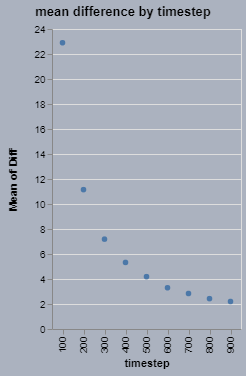

mean percent difference:


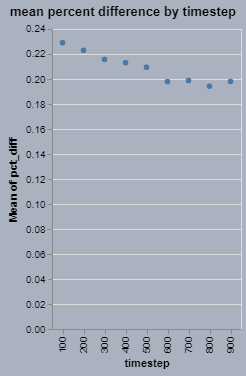

In [8]:
OP.plot_mean_differences()

## sim vs real comparison

In [ ]:
#----------------------- bar chart -----------------------
sel_iter_var = alt.selection_single(encodings=['y'])

bar_chart = alt.Chart(
    OP.full_comp_df,
    #.sample(frac=0.1),
    width=250,
    height=800
).mark_bar(
).encode(
    alt.X('mean(Diff):Q'),
    alt.Y(f'{OP.iter_var}:N'),
    color=alt.condition(
        sel_iter_var,
        f'{OP.iter_var}:N',
        alt.value('#96989b'),
        legend=None
    )
).add_selection(
    sel_iter_var
)
#.configure(background='#abb2bf')


#----------------------- signals -----------------------

x_scaler = alt.selection_interval(encodings=['x'])

base = alt.Chart(
    OP.full_comp_df.reset_index().sample(frac=0.5),
    height=200,
    width=800
).transform_filter(
    sel_iter_var
).mark_line(
    opacity=0.5
).encode(
    alt.X('index:Q', scale={'domain': x_scaler.ref()}),
    #alt.Y('real_data:Q')
)

layered = alt.vconcat(
    base.encode(
        alt.Y('real_data:Q'),
        #color=alt.value('#4286f4') # blue
        color=f'{OP.iter_var}:N'
    ).transform_filter(x_scaler),
    base.encode(
        alt.Y('sim_data:Q'),
        #color=alt.value('#41f470') # green
        color=f'{OP.iter_var}:N'
    ).transform_filter(x_scaler),
    base.encode(
        alt.Y('Diff:Q'),
        #color=alt.value('#f44141') # red
        color=f'{OP.iter_var}:N'
    ).transform_filter(x_scaler),
)

wide = base.encode(alt.Y('Diff:Q')).add_selection(x_scaler).properties(height=100)

signal_concat = alt.vconcat(
    layered, 
    wide
)

alt.hconcat(
    bar_chart,
    signal_concat,
    background='#abb2bf'
)



## misfits